# Data Science Project: Investigation into Medical Devices
Dane Lacey, Sidney Washburn, Shravan Parthasarathy

View video [here](https://youtu.be/BcbCYR8zyxQ).

#### Brief Background and Recap
When purchasing a medical device -- say, a pacemaker -- one would like to know how safe the device is. To answer this question, the history of responsiveness of the firm and where the device was manufactured are of immediate interest. One would not wish to purchase any kind of medical device from a firm that has poor, or even non-existent, the response time when a device of theirs is recalled.

Our goal is twofold: to determine where a device is likely to be made based on its description and to determine a reliability measure on which medical device firms can be based on. We believe this will provide information to the consumer, so that they may make a more informed decision when purchasing a medical device.

#### Data Acquisition and Cleanup
Data was first acquired from the FDA's website. Initially, only data from the [FDA Recall database](https://www.accessdata.fda.gov/scripts/cdrh/cfdocs/cfRES/res.cfm) was collected, in the form of a monthly CSV, from January 2014 to December 2018. However, since our intention was to analyze how fast a company would recall their device, we instead considered recall data from January 2010 to December 2014, as we figured that a minimum of four years would be a reasonable amount of time for a company to address a recall. In order for these (60) CSV files to readable by Pandas, they had to be manually converted to UTF-8 via Microsoft Excel. Lastly, they were all loaded into a Pandas dataframe and exported into a single dataframe for use for the rest of our project (`All_recall_data`).

In an attempt to cross-correlate the data from the recall database to other parameters, such as a company's location and their device reports, we also downloaded the [Manufacturer and User Facility Data for 2010-2014](https://www.accessdata.fda.gov/scripts/cdrh/cfdocs/cfMAUDE/search.CFM). This was also from the FDA and contains information on the devices that have been reported in the time between 2010 and 2014. Since these were `.xlsx` files, they also had to be converted to UTF-8 manually and were read into and exported as a dataframe (`manufacture_data`). This was especially important as this file was particularly large. 

Over the duration of our analysis, we realized that cross-correlation was not possible, and decided to split the project into two parts. Each of these parts sets out to answer a question, whos answer is derived with the its respective database. The question "How do we determine where a device is made, based on it's product description?" is answered using databases "manu_data", "cities", and "zip_codes" in part 1, and "How to determine the reliability of a firm?" is answered using "All_recall_data" in part 2. Of course, throughout our analysis other questions arrose that needed to be answered. In the duration of our project, there we some questions we could answer with the given data, and some we could not.

In [1]:
#Imports
import pandas as pd
import csv
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import numpy as np
import time
from datetime import datetime
from sklearn.neighbors import  KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import metrics
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from sklearn.naive_bayes import MultinomialNB
from collections import Counter
from matplotlib import cm
from matplotlib.pyplot import figure
import scipy as sc
from scipy.stats import norm
import statsmodels.formula.api as sm
from sklearn import linear_model

%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 6)

devices = pd.read_csv('manu_data_latlong', encoding='utf-8') #Device reports data
recall_df = pd.read_csv('All_recall_data.txt', encoding='utf-8') #Recalled devices data

/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (3,4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Part 1

We set out to answer our first question: "How do we determine where a device is made, based on it's product description?". In this part, we visualize where the devices we are considering actually come from. Then, we use insight gleaned from these visualization and Naive Bayes classifiers to derive a probabilistic model to answer our question. 

The following code used to obtain the longitude/latitude of the devices uses databases from [Simple Maps](https://simplemaps.com/data/us-cities) and [United States Zip Codes](https://www.unitedstateszipcodes.org/zip-code-database/). We also used the abbreviations of states in the U.S. to hopefully increase the number of entries we get. The code takes at least 40 minutes to run so the results are stored in a csv called "manu_data_latlong".

In [2]:
# manu_data = pd.read_csv('ManufactureData/manufacture_data(csv).txt', encoding='latin')
# cities = pd.read_csv('simplemaps_worldcities_basicv1.4/worldcities.csv', encoding='utf-8')
# zip_codes = pd.read_csv('ManufactureData/zip_code_database.csv', encoding='utf-8')
# #Reading in the abbreviations for states
# st_abbr = []
# with open('State_abbr.txt', encoding='utf-8') as abbr:
#     abbr_csv = csv.reader(abbr, delimiter='-', quotechar='"')
#     for state in abbr_csv:
#         st_abbr.append(state)

# def rreplace(s, old, new, occurrence):
#     li = s.rsplit(old, occurrence)
#     return new.join(li)
# for row in range(len(st_abbr)):
#     for col in range(2):
#         if(col==0):
#             st_abbr[row][col] = rreplace(st_abbr[row][col], ' ', '', 1)
#         else:
#             st_abbr[row][col] = rreplace(st_abbr[row][col], ' ', '', 2)
            
# st_abbr[0][0] = st_abbr[0][0][1:]
# st_abbr.append(['nan', 'nan'])
# st_abbr_df = pd.DataFrame(st_abbr)
# for i in range(2):
#     st_abbr_df.rename(columns={i:st_abbr_df[i][0]}, inplace=True)
# st_abbr_df.drop([0], inplace=True)
# st_abbr_df.set_index(keys=st_abbr_df['Abbr.'], inplace=True)
# st_abbr_df = st_abbr_df['State']
# #State Abbreviations ^^^^^


# #Getting longitude/latitude for each device
# manu_data_cities = manu_data['MANUFACTURER_D_CITY']
# long = []
# lat = []
# cities = cities.set_index(keys=cities['city'].apply(lambda x: x.upper()))
# cities_bystate = cities.set_index(keys=cities['admin_name'].apply(lambda x: str(x).upper()))
# zip_bystate = zip_codes.set_index(keys=zip_codes['state'])
# zip_byzip = zip_codes.set_index(keys=zip_codes['zip'])
# for i in range(len(manu_data)):
#     print(i)
#     try:
#         state = str(st_abbr_df[str(manu_data['MANUFACTURER_D_STATE_CODE'].iloc[i])])
#     except KeyError:
#         state = 'nan'
#     city = str(manu_data['MANUFACTURER_D_CITY'].iloc[i]).upper()
#     zip_ = manu_data['MANUFACTURER_D_ZIP_CODE'].iloc[i]
#     try:
#         if (str(type(cities.loc[city])) == "<class 'pandas.core.series.Series'>"):
#             long.append(cities.loc[city]['lng'])
#             lat.append(cities.loc[city]['lat'])
#         elif (str(zip_) != 'nan'):
#             try:
#                 long.append(zip_byzip.loc[zip_]['longitude'])
#                 lat.append(zip_byzip.loc[zip_]['latitude'])
#             except KeyError:
#                 if (state != 'nan'):
#                     try:
#                         #just take the first long/lat
#                         long.append(cities_bystate[cities_bystate['country']=='United States'].loc[state]['lng'].iloc[0])
#                         lat.append(cities_bystate[cities_bystate['country']=='United States'].loc[state]['lat'].iloc[0])
#                     except KeyError:
#                         long.append(None)
#                         lat.append(None)
#                 else:
#                     long.append(None)
#                     lat.append(None)
#         elif (state != 'nan'):
#             try:
#                 #just take the first long/lat
#                 long.append(cities_bystate[cities_bystate['country']=='United States'].loc[state]['lng'].iloc[0])
#                 lat.append(cities_bystate[cities_bystate['country']=='United States'].loc[state]['lat'].iloc[0])
#             except KeyError:
#                 long.append(None)
#                 lat.append(None)
#         else:
#             long.append(None)
#             lat.append(None)
#     except KeyError:
#         if(str(zip_) != 'nan'):
#             try:
#                 long.append(zip_byzip.loc[zip_]['longitude'])
#                 lat.append(zip_byzip.loc[zip_]['latitude'])
#             except KeyError:
#                 if (state != 'nan'):
#                     try:
#                         #just take the first long/lat
#                         long.append(cities_bystate[cities_bystate['country']=='United States'].loc[state]['lng'].iloc[0])
#                         lat.append(cities_bystate[cities_bystate['country']=='United States'].loc[state]['lat'].iloc[0])
#                     except KeyError:
#                         long.append(None)
#                         lat.append(None)
#                 else:
#                     long.append(None)
#                     lat.append(None)
#         elif (state != 'nan'):
#             try:
#                 #just take the first long/lat
#                 long.append(cities_bystate[cities_bystate['country']=='United States'].loc[state]['lng'].iloc[0])
#                 lat.append(cities_bystate[cities_bystate['country']=='United States'].loc[state]['lat'].iloc[0])
#             except KeyError:
#                 long.append(None)
#                 lat.append(None)
#         else:
#             long.append(None)
#             lat.append(None)
            
# #^^^^^^ Takes a while to run so we put the results into a csv

# manu_data['latitude'] = long
# manu_data['longitude'] = lat
# manu_data.to_csv('manu_data_latlong', encoding='utf-8')

In [3]:
print('Number of devices in total:', len(devices))
# The latitude/longitude columns are backwards so this part switches them to the right place
dev_longlat = devices.dropna(subset=['latitude', 'longitude'])
dev_longlat.rename(columns={'latitude': 'long', 'longitude': 'lat'}, inplace=True)
print('Number of devices with long/lat data:', len(dev_longlat))
print(list(dev_longlat.head()))
dev_longlat.head()

Number of devices in total: 1286024
Number of devices with long/lat data: 533829
['Unnamed: 0', 'Unnamed: 0.1', 'MDR_REPORT_KEY', 'DEVICE_EVENT_KEY', 'IMPLANT_FLAG', 'DATE_REMOVED_FLAG', 'DEVICE_SEQUENCE_NO', 'DATE_RECEIVED', 'BRAND_NAME', 'GENERIC_NAME', 'MANUFACTURER_D_NAME', 'MANUFACTURER_D_ADDRESS_1', 'MANUFACTURER_D_ADDRESS_2', 'MANUFACTURER_D_CITY', 'MANUFACTURER_D_STATE_CODE', 'MANUFACTURER_D_ZIP_CODE', 'MANUFACTURER_D_ZIP_CODE_EXT', 'MANUFACTURER_D_COUNTRY_CODE', 'MANUFACTURER_D_POSTAL_CODE', 'EXPIRATION_DATE_OF_DEVICE', 'MODEL_NUMBER', 'CATALOG_NUMBER', 'LOT_NUMBER', 'OTHER_ID_NUMBER', 'DEVICE_OPERATOR', 'DEVICE_AVAILABILITY', 'DATE_RETURNED_TO_MANUFACTURER', 'DEVICE_REPORT_PRODUCT_CODE', 'DEVICE_AGE_TEXT', 'DEVICE_EVALUATED_BY_MANUFACTUR', 'long', 'lat']


/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3781: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


,Unnamed: 0,Unnamed: 0.1,MDR_REPORT_KEY,DEVICE_EVENT_KEY,IMPLANT_FLAG,DATE_REMOVED_FLAG,DEVICE_SEQUENCE_NO,DATE_RECEIVED,BRAND_NAME,GENERIC_NAME,...,LOT_NUMBER,OTHER_ID_NUMBER,DEVICE_OPERATOR,DEVICE_AVAILABILITY,DATE_RETURNED_TO_MANUFACTURER,DEVICE_REPORT_PRODUCT_CODE,DEVICE_AGE_TEXT,DEVICE_EVALUATED_BY_MANUFACTUR,long,lat
0,0,0,4172003.0,NaN,NaN,NaN,1.0,2014-10-10,NATURALYTE,NaN,...,NaN,NaN,0HP,N,NaN,KPO,DA,R,-71.2423,42.3889
3,3,3,3660909.0,NaN,NaN,NaN,1.0,2014-03-05,G4 PLATINUM CONTINUOUS GLUCOSE MONITORING SYSTEM,MDS,...,5120291,NaN,0LP,N,NaN,MDS,NaN,R,-117.1225,32.8312
4,4,4,3932174.0,NaN,NaN,NaN,1.0,2014-07-14,ONETOUCHPING GLUCOSEMGMTSYSTEM,INSULIN INFUSION PUMP,...,NaN,1-MCBC-64,0LP,R,2014-07-25,LZG,10 MO,Y,-75.6058,39.9601
6,6,6,3928208.0,NaN,NaN,NaN,1.0,2014-07-11,OT VERIO IQ METER,GLUCOSE MONITORING SYS/KIT,...,3513060,NaN,0LP,N,NaN,NBW,NaN,R,8.4870,47.1790
7,7,7,3929055.0,NaN,NaN,NaN,1.0,2014-06-19,R SERIES DEFIBRILLATOR,DEFIBRILLATOR/PACEMAKER,...,NaN,NaN,0HP,N,NaN,MKJ,DA,R,0.4833,51.7333


The code above was only able to retrieve longitude/latitude data for approximately 1/2 of the data. This is partly since a good portion of the devices have to no information on the location of the manufacturer. Another factor leading to only retrieving 1/2 of the data is the databases we used to get the longitude and latitude. The database containing the cities only has 13,000 cities listed. However, despite only having 13,000 cities, the cities in the database are listed across the world and are "major" cities which indicate the region where a device is. Because of this, we believe that even though we could only acquire half of reports, this half will still be representative of the overall trend for where the devices are located.

In [4]:
dev_longlat = dev_longlat.drop(['Unnamed: 0', 'Unnamed: 0.1', 'MDR_REPORT_KEY', 'DEVICE_EVENT_KEY', 'IMPLANT_FLAG',
                                'DATE_REMOVED_FLAG', 'DEVICE_SEQUENCE_NO', 'MODEL_NUMBER', 'CATALOG_NUMBER', 'LOT_NUMBER',
                                'OTHER_ID_NUMBER', 'DEVICE_OPERATOR','DEVICE_REPORT_PRODUCT_CODE', 'DEVICE_AGE_TEXT'], axis=1)
dev_longlat.head()

,DATE_RECEIVED,BRAND_NAME,GENERIC_NAME,MANUFACTURER_D_NAME,MANUFACTURER_D_ADDRESS_1,MANUFACTURER_D_ADDRESS_2,MANUFACTURER_D_CITY,MANUFACTURER_D_STATE_CODE,MANUFACTURER_D_ZIP_CODE,MANUFACTURER_D_ZIP_CODE_EXT,MANUFACTURER_D_COUNTRY_CODE,MANUFACTURER_D_POSTAL_CODE,EXPIRATION_DATE_OF_DEVICE,DEVICE_AVAILABILITY,DATE_RETURNED_TO_MANUFACTURER,DEVICE_EVALUATED_BY_MANUFACTUR,long,lat
0,2014-10-10,NATURALYTE,NaN,FRESENIUS MEDICAL CARE NORTH AMERICA,NaN,NaN,WALTHAM,MA,NaN,NaN,US,NaN,NaN,N,NaN,R,-71.2423,42.3889
3,2014-03-05,G4 PLATINUM CONTINUOUS GLUCOSE MONITORING SYSTEM,MDS,"DEXCOM, INC.",6340 SEQUENCE DRIVE,NaN,SAN DIEGO,CA,92121,NaN,US,92121,2014-08-14,N,NaN,R,-117.1225,32.8312
4,2014-07-14,ONETOUCHPING GLUCOSEMGMTSYSTEM,INSULIN INFUSION PUMP,ANIMAS CORPORATION,200 LAWRENCE DR,NaN,WEST CHESTER,PA,19380,342,US,19380 3428,NaN,R,2014-07-25,Y,-75.6058,39.9601
6,2014-07-11,OT VERIO IQ METER,GLUCOSE MONITORING SYS/KIT,"LIFESCAN EUROPE, A DIVISION OF CILAG GMBH INTL",GUBELSTRASSE 34,NaN,ZUG,NaN,6300,NaN,SZ,6300,NaN,N,NaN,R,8.4870,47.1790
7,2014-06-19,R SERIES DEFIBRILLATOR,DEFIBRILLATOR/PACEMAKER,ZOLL MEDICAL CORPORATION,NaN,NaN,CHELMSFORD,MA,NaN,NaN,US,NaN,NaN,N,NaN,R,0.4833,51.7333


The database containing the information has a quite a few columns of data which don't have much information on the actual device so we only kept columns like the dates, location data, and other columns which might have information on the device.

With the clean-up out of the way, let's now first plot the data we have as a scatterplot and then overlay it onto a world map so we can get a sense for where the devices that have accrued reports are located. To do this, we used cartopy (https://pypi.org/project/Cartopy/).

/anaconda3/lib/python3.7/site-packages/cartopy/io/__init__.py:260: DownloadWarning: Downloading: http://naciscdn.org/naturalearth/110m/physical/ne_110m_coastline.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)


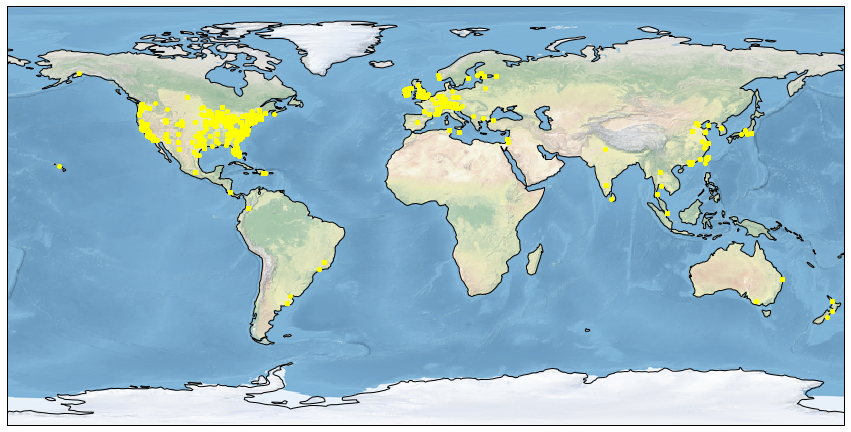

In [5]:
fig = plt.figure(figsize=(15, 12))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

# make the map global rather than have it zoom in to
# the extents of any plotted data
ax.set_global()

ax.stock_img()
ax.coastlines()
ax.plot(dev_longlat['long'],dev_longlat['lat'], 'o', color='yellow', markersize=4, transform=ccrs.PlateCarree())

plt.show()


From the map, it seems that most of the devices are in North America, Europe, and the East Coast of Asia. On the East Asian Coast, it seems that most of the devices are in China and Japan. However, since this is a scatter plot, it's hard to discern one point from 1000 points so let's use a heatmap instead to see where the largest concentrations of reported devices are being manufactured.

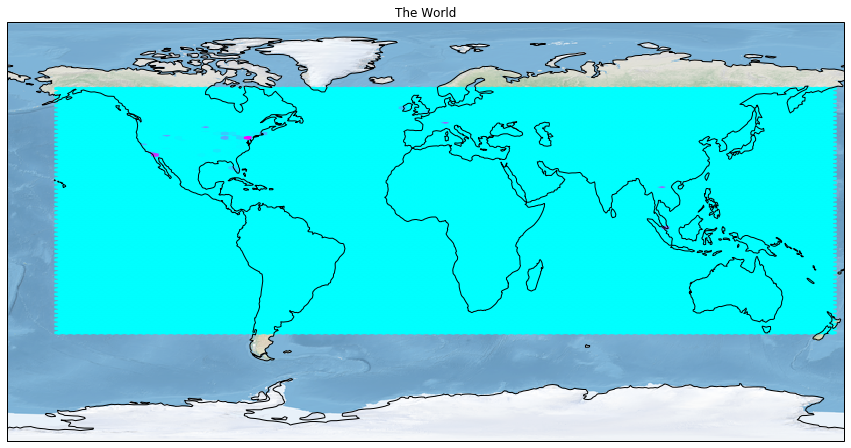

In [6]:
#World Map
fig = plt.figure(figsize=(15, 12))
EAC = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

# make the map global rather than have it zoom in to
# the extents of any plotted data
EAC.set_global()

EAC.stock_img()
EAC.coastlines()

EAC.hexbin(dev_longlat['long'],dev_longlat['lat'],cmap='cool', transform=ccrs.PlateCarree())
plt.title('The World')
plt.show()

For the map above, we used a hexbin plot, which overlays hexagons onto the scatterplot and assigns a color to each hexagon based on how many points fall inside that hexagon. We used "cool" color map where light blue hexagon indicates the smallest number of reports in that hexagon while light purple indicates the greatest number of reports. Unfortunately, cartopy does not support matplotlib's hexbin so it doesn't cover the entire world nor does the color bar show up. Luckily however, we can see that the portions of the map which are not covered aren't relevant to our data since there are nearly no devices in those portions, as indicated by the scatter plot above. This heatmap is hard to read on it's surface so lets zoom in on individual regions to better see how the devices are distributed.

/anaconda3/lib/python3.7/site-packages/cartopy/io/__init__.py:260: DownloadWarning: Downloading: http://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_0_boundary_lines_land.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)


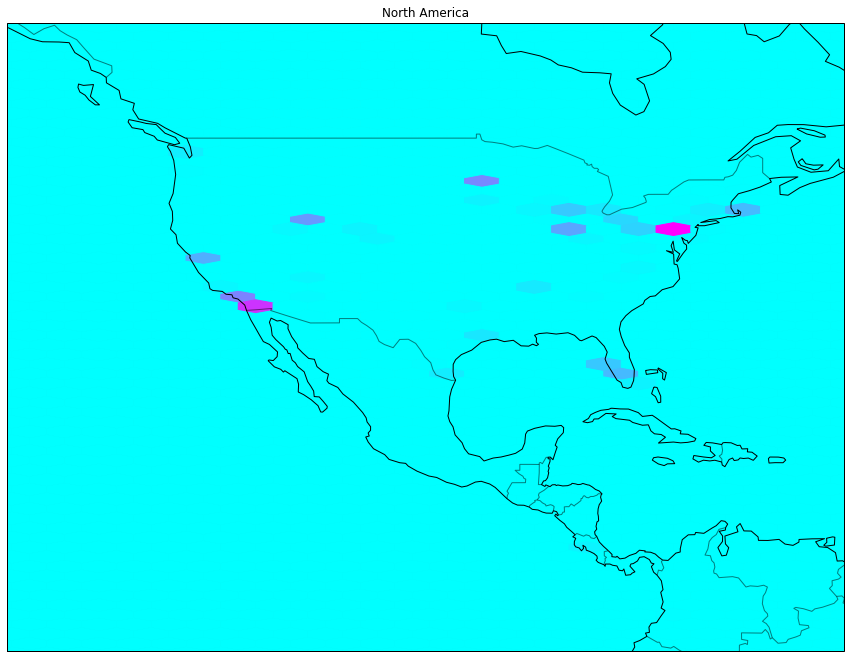

In [7]:
fig = plt.figure(figsize=(15, 12))
#North America
NA = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

# make the map global rather than have it zoom in to
# the extents of any plotted data
NA.set_global()

NA.stock_img()
NA.coastlines()

# Unfortunately, cartopy doesn't support matplotlib's hexbin so the colorbar isn't showing up and the heatmap doesn't cover 
# the entire world
NA.add_feature(cartopy.feature.BORDERS, linestyle='-', alpha=0.5)
NA.hexbin(dev_longlat['long'],dev_longlat['lat'],cmap='cool', transform=ccrs.PlateCarree())
NA.set_extent([-140,-60,0,60], crs=ccrs.PlateCarree())
plt.title('North America')
plt.show()


Here in the North America, the heatmap indicates that there is a large concentration in the both New York area and the Southern California area.

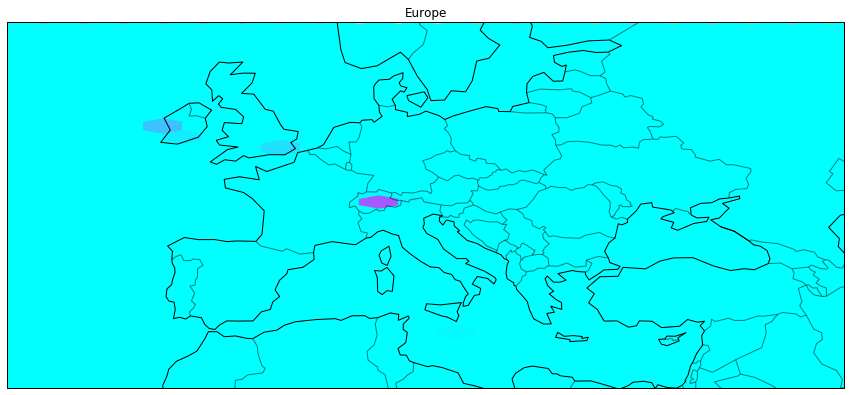

In [8]:
#Europe
fig = plt.figure(figsize=(15, 12))
EU = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

# make the map global rather than have it zoom in to
# the extents of any plotted data
EU.set_global()

EU.stock_img()
EU.coastlines()
EU.add_feature(cartopy.feature.BORDERS, linestyle='-', alpha=0.5)
EU.hexbin(dev_longlat['long'],dev_longlat['lat'],cmap='cool', transform=ccrs.PlateCarree())
EU.set_extent([-23,48,31,62], crs=ccrs.PlateCarree())
plt.title('Europe')
plt.show()

As we can see above, the largest concentration of devices in Europe are in Switzerland and the only other notable pockets of devices are in Britain.

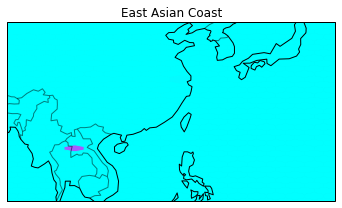

In [9]:
#East Asian Coast
fig = plt.figure(figsize=(20, 18))
EAC = fig.add_subplot(1, 3, 1, projection=ccrs.PlateCarree())

# make the map global rather than have it zoom in to
# the extents of any plotted data
EAC.set_global()

EAC.stock_img()
EAC.coastlines()
EAC.add_feature(cartopy.feature.BORDERS, linestyle='-', alpha=0.5)
EAC.hexbin(dev_longlat['long'],dev_longlat['lat'],cmap='cool', transform=ccrs.PlateCarree())
EAC.set_extent([90,147,10,41], crs=ccrs.PlateCarree())
plt.title('East Asian Coast')
plt.show()

Contrary to the scatter plot from above, we can see that the largest concentration of devices in East Asia are actually in Laos, not China or Japan.

Now that we've seen how the devices are distributed across the world, we now want to see if it's possible to predict the location based on the description for the devices using the Naive Bayes Classifier. The reason we want to check this is because for a given region, we believe that the devices which are manufactured there are going to be relatively similar to each other. Under the assumption that the devices are similar, the generic description of the device should also be similar to others in its region.

In [10]:
# Finding the difference, in days, between the expiration date of the device and the date the report was recieved
def days_between(d1, d2):
    dformat = "%Y-%m-%d"
    d1 = datetime.strptime(d1, dformat)
    d2 = datetime.strptime(d2, dformat)
    return abs((d2 - d1).days)
dev_exp = dev_longlat.dropna(subset=['EXPIRATION_DATE_OF_DEVICE','DATE_RECEIVED'])

# Defining the location of a device based on it's longitude and latitude
def location(long, lat):
    if(-108<long<=-88 and 21<=lat<=54): # Western U.S.
        return "USMW"
    elif(-128<=long<=-108 and 21<=lat<=54): # U.S. Midwest
        return "USW"
    elif(-88<long<=-63 and 19<=lat<=54): #Eastern U.S.
        return "USE"
    elif(32<=lat<=63 and -15<=long<=56): #Europe's long/lat
        return "EU"
    elif(7<=lat<=49 and 94<=long<=150): #East Asian Coast's long/lat
        return "EAC"
    else:
        return "Elsewhere"
dev_exp['location'] = dev_exp[['long','lat']].apply(lambda x: location(x['long'],x['lat']), axis=1)
# X_train, X_test, y_train, y_test = train_test_split(dev_exp[['long','lat']], dev_exp['days_dscr'],
#                                                     random_state=1, test_size=0.8)

#Going to predict the location based on the desciption of the device (generic name of the device)
dev_exp_names = dev_exp.dropna(subset=['GENERIC_NAME'])
#Vectorizing the names
gen_names = []
for name in dev_exp_names['GENERIC_NAME']:
    gen_names.append(str(name))

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Since there are two ways to vectorize the descriptions of the devices (`Count` and `Tfidf`), we decided to check both vectorizer's accuracy and plot the accuracy for each with alpha values ranging from 0.05 to 1.0.

In [11]:
for region in ["USMW","USW","USE","EU","EAC"]:
    print(region + ":", len(dev_exp_names[dev_exp_names['location'] == region])/len(dev_exp_names))

USMW: 0.17238413860368534
USW: 0.37097670711371666
USE: 0.20067959434090885
EU: 0.11776488972323311
EAC: 0.09949554802781303


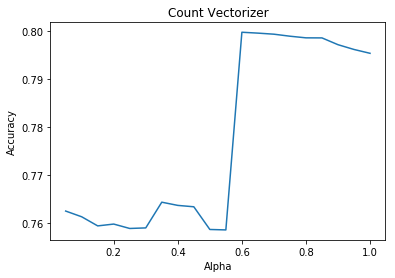

Highest Accuracy: 0.799779761670665
Alpha = 0.6000000000000001


In [12]:
#Finding best alpha for the NB model
countv = CountVectorizer(stop_words=stopwords.words('english'))
X = countv.fit_transform(gen_names)
y = dev_exp_names['location']
accuracies = []
alpha = []
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, test_size=0.8)
for a in np.arange(0.05, 1.05, .05):
    nb_model = MultinomialNB(alpha=a)
    nb_model.fit(X_train, y_train)
    y_pred = nb_model.predict(X_test)
    accuracies.append(metrics.accuracy_score(y_true=y_test, y_pred=y_pred))
    alpha.append(a)
plt.plot(alpha,accuracies)
plt.title('Count Vectorizer')
plt.xlabel('Alpha')
plt.ylabel('Accuracy')
plt.show()
print('Highest Accuracy:',max(accuracies))
print('Alpha =',alpha[accuracies.index(max(accuracies))])

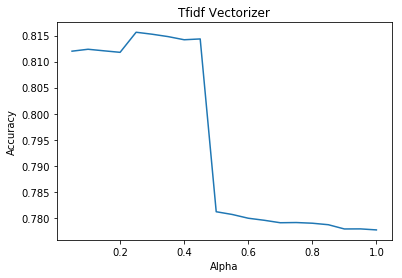

Highest Accuracy: 0.815629055728163
Alpha = 0.25


In [13]:
tfidfv = TfidfVectorizer(stop_words=stopwords.words('english'))
X = tfidfv.fit_transform(gen_names)
y = dev_exp_names['location']
accuracies = []
alpha = []
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, test_size=0.8)
for a in np.arange(0.05, 1.05, .05):
    nb_model = MultinomialNB(alpha=a)
    nb_model.fit(X_train, y_train)
    y_pred = nb_model.predict(X_test)
    accuracies.append(metrics.accuracy_score(y_true=y_test, y_pred=y_pred))
    alpha.append(a)
plt.plot(alpha,accuracies)
plt.title('Tfidf Vectorizer')
plt.xlabel('Alpha')
plt.ylabel('Accuracy')
plt.show()
print('Highest Accuracy:',max(accuracies))
print('Alpha =',alpha[accuracies.index(max(accuracies))])

## Part 2

We then begin to try to answer the question "How to determine the reliability of a firm?". To do this, we first derive a metric to determine how "reliable" the firms we are considering tend to be and try to correlate that metric (recall_score) with the severity of the recalls (avergae_recall_class). Then, we make some useful observations and visualizations of when exactly devices tend to be recalled. As a last step in our analysis in part 2, we try to see if the description and the recall reason are good predictors of the month that a device was recalled in.

It is not accurate to assume that just because a medical firm recalls a lot of devices, that it is a bad firm. It may simply be larger than other firms, thus producing more devices. To rectify this, I assign each of the firms we are considering (the firms with over 10 recalls) a "recall score", where $$ \text{recall score} = \frac{\text{total # days before recall addressed}}{\text{# recalls}}. $$ This will "normalize" the data, and give us one measure of how reliable a firm is. That is, how quickly we can expect them to address a recalled product.

The immediate issue is that, out of the firms with over 10 products recalled in the 2010-2014 timespan ("lst"), some have similar names. This is because these similarly named firms are subsidiaries of the same firm. We group the similarly named firms into umbrella firms by the following (considerable) hard-code.

In [14]:
recalls = recall_df
recalls = recalls.drop(['Unnamed: 0'], axis = 1)

In [15]:
main_firms = {
    "Stryker": ["Stryker Endoscopy", "Stryker Howmedica Osteonics Corp.", "Stryker Instruments Div. of Stryker Corporation", 'Stryker Craniomaxillofacial Division','Stryker Instruments Division of Stryker Corporation', 'Stryker Medical Division of Stryker Corporation', 'Stryker Spine', 'Stryker Neurovascular', 'Stryker Neurovascular', 'Stryker Communications Corp', 'Orthovita, Inc., dBA Stryker Orthobiologics.', 'Stryker Medical Div. of Stryker Corporation' ], 
    "Customed": ["Customed, Inc"], 
    "Zimmer" : ["Zimmer, Inc.", 'Zimmer Inc.'],
    'GE Healthcare' : ['GE Healthcare, LLC', 'GE OEC Medical Systems, Inc', 'Ge Healthcare It', 'GE Healthcare', 'GE Healthcare It', 'Ge Healthcare, Llc'],
    'Terumo Cardiovascular Systems' : ['Terumo Cardiovascular Corporation', 'Terumo Cardiovascular Systems Corp', 'Terumo Cardiovascular Systems Corporation'],
    'Boston Scientific' : ['Boston Scientific Corporation', 'Boston Scientific CRM Corp', 'Boston Scientific Corporation, Neurovascular, 47900 Bayside Parkway, Fremont, CA 94538'],
    'Biomet' : ['Biomet, Inc.', 'Biomet Microfixation, LLC', 'Biomet 3i, LLC', 'Biomet Microfixation, Inc.'],
    'Beckman' : ['Beckman Coulter Inc.'],
    'Hospira' : ['Hospira Inc.'],
    'Cook' : ['Cook, Inc.'],
    'Biomerieux' : ['Biomerieux Inc'],
    'The Anspach Effort' : ['The Anspach Effort, Inc.'],
    'Smith & Nephew' : ['Smith & Nephew Inc', 'Smith & Nephew, Inc. Endoscopy Division', 'Smith & Nephew Inc.'],
    'Siemens' : ['Siemens Medical Solutions USA, Inc - Radiation Oncology', 'Siemens Healthcare Diagnostics Inc', 'Siemens Healthcare Diagnostics','Siemens Healthcare Diagnostics, Inc.', 'Siemens Medical Solutions USA, Inc', 'Siemens Medical Solutions USA,  Inc', 'Siemens Healthcare Diagnostics, Inc', 'Siemens Medical Solutions USA, Inc.' ],
    "Philips" : ['Philips Healthcare Inc.', 'Philips Medical Systems (Cleveland) Inc', 'Philips Medical Systems North America Co.   Phillips', 'Philips Medical Systems', 'Philips Medical Systems, Inc.'],
    'ICU Medical' : ['ICU Medical, Inc.'],
    'Baxter Healthcare' : ['Baxter Healthcare Corp.'],
    'Teleflex Medical' : ['Teleflex Medical', 'Arrow International, Inc., Division of Teleflex Medical Inc.','Arrow International Inc'],
    'Heritage Labs' : ['Heritage Labs International LLC'],
    'Depuy' : ['DePuy Spine, Inc.', 'Depuy Orthopaedics, Inc.', 'DePuy Orthopaedics, Inc.', 'DePuy Mitek, Inc., a Johnson & Johnson Co.'],
    'Ortho-Clinical Diagnostics' : ['Ortho-Clinical Diagnostics'],
    'Centurion' : ['Centurion Medical Products Corporation', 'Centurion Medical Products'],
    'Angiodynamics' : ['Angiodynamics Worldwide Headquarters', 'Angiodynamics, Inc.', 'Angiodynamics, INC'],
    'Smiths Medical' : ['Smiths Medical ASD, Inc.', 'Smiths Medical'],
    'Integra LifeSciences' : ['Integra LifeSciences Corp.', 'Integra LifeSciences Corporation', 'Integra LifeSciences Corp. d.b.a. Integra Pain Management'],
    'Intuitive Surgical' : ['Intuitive Surgical, Inc.'],
    'Sorin Group' : ['Sorin Group USA, Inc.', 'Sorin Group Deutschland GmbH'],
    'Codman & Shurtleff' : ['Codman & Shurtleff, Inc.'],
    'LumiQuick Diagnostics' : ['LumiQuick Diagnostics Inc.'],
    'Elekta' : ['Elekta, Inc.'],
    'Becton Dickinson' : ['Becton Dickinson & Co.', 'Becton Dickinson Medical Systems', 'Becton Dickinson & Company'],
    'Covidien' : ['Covidien LP', 'Nellcor Puritan Bennett Inc. (dba Covidien Ltd)', 'Covidien LLC','Nellcor Puritan Bennett Inc. (dba Covidien LP)'],
    'Synthes' : ['Synthes USA (HQ), Inc.', 'Synthes USA HQ, Inc.', 'Synthes, Inc.'],
    'Multi-Med' : ['Multi-Med, Inc.'],
    'Varian Medical Systems' : ['Varian Medical Systems, Inc. Oncology Systems', 'Varian Medical Systems, Inc.', 'Varian Medical Systems Oncology Systems'],
    'Nurse Assist' : ['Nurse Assist, Inc'],
    'Merit Medical' : ['Merit Medical Systems, Inc.'],
    'Instrumed International' : ['Instrumed International, Inc.'],
    'Carestream Health' : ['Carestream Health Inc.','Carestream Health, Inc.'],
    'Medtronic' : ['Medtronic Navigation, Inc.', 'Medtronic Inc. Cardiac Rhythm Disease Management', 'Medtronic Sofamor Danek USA Inc', 'Medtronic Neuromodulation', 'Medtronic Inc. Cardiac Rhythm Disease Managment', 'Medtronic Vascular'],
    'Toshiba' : ['Toshiba American Medical Systems Inc'],
    'ConMed' : ['ConMed Corporation', 'Linvatec Corp. dba ConMed Linvatec', 'ConMed Electrosurgery'],
    'Roche' : ['Roche Diagnostics Operations, Inc.', 'Roche Molecular Systems, Inc.', 'Roche Insulin Delivery Systems Inc.'],
    'Fresenius Medical Care Holdings' : ['Fresenius Medical Care Holdings, Inc.'],
    'King Systems' : ['King Systems Corp.'],
    'Zevex International' : ['Zevex International, Inc.'],
    'Medical Device Technologies' : ['Medical Device Technologies, Inc.'],
    'Abbott' : ['Abbott Laboratories', 'Abbott Diabetes Care, Inc.', 'Abbott Point Of Care Inc.', 'Abbott Point of Care Inc.', 'Abbott Molecular'],
    'Wright Medical Technology' : ['Wright Medical Technology Inc'],
    'Innovatech Medical Resources' : ['Innovatech Medical Resources L.P.'],
    'Instrumentation Laboratory' : ['Instrumentation Laboratory Co.'],
    'Atrium Medical' : ['Atrium Medical Corporation'],
    'Ethicon' : ['Ethicon Endo-Surgery Inc', 'Ethicon, Inc.'],
    'Advanced Sterilization' : ['Advanced Sterilization Products'],
    'Applied Medical Resources' : ['Applied Medical Resources Corp'],
    'Hill-Rom' : ['Hill-Rom, Inc.'],
    'Bausch & Lomb' : ['Bausch & Lomb Inc'],
    'Remel' : ['Remel Inc'],
    'MOOG' : ['MOOG Medical Devices Group'],
    'SpineFrontier' : ['SpineFrontier, Inc.'],
    'Steris' : ['Steris Corporation'],
    'Argon Medical Devices' : ['Argon Medical Devices, Inc'],
    'Endotec' : ['Endotec, Inc.'],
    'Edwards Lifesciences' : ['Edwards Lifesciences, LLC'],
    'Computerized Medical Systems' : ['Computerized Medical Systems Inc'],
    'Cardinal' : ['Cardinal Health', 'Cardinal Health, Medical Products & Services'],
    'NuVasive' : ['NuVasive Inc'],
    'AGFA' : ['AGFA Corp.'],
    'Navilyst Medical' : ['Navilyst Medical, Inc'],
    'SCC' : ['SCC Soft Computer'],
    'DeRoyal Industries' : ['DeRoyal Industries Inc', 'Deroyal Industries, Inc. Lafollette'],
    'Baxa' : ['Baxa Corporation'],
    'Cardiac Science' : ['Cardiac Science Corporation'],
    'Oridion Medical' : ['Oridion Medical 1987 Ltd.'],
    'Leica Microsystems' : ['Leica Microsystems, Inc.'],
    'Orthopediatrics' : ['Orthopediatrics Corp', 'OrthoPediatrics Corp'],
    'Aspen Surgical Products' : ['Aspen Surgical Products, Inc.'],
    'Spacelabs Healthcare' : ['Spacelabs Healthcare, Llc'],
    'Churchill Medical Systems' : ['Churchill Medical Systems, Inc.'],
    'Bio-Rad Laboratories' : ['Bio-Rad Laboratories Inc', 'Bio-Rad Laboratories, Inc.'],
    'Alere' : ['Alere San Diego, Inc.', 'Alere San Diego'],
    'Calbiotech' : ['Calbiotech Inc'],
    'C.R. Bard' : ['Bard Peripheral Vascular Inc', 'Bard Access Systems', 'Davol, Inc., Subs. C. R. Bard, Inc.', 'Davol, Inc., Sub. C. R. Bard, Inc.'],
    'Tripath Imaging' : ['Tripath Imaging, Inc.'],
    'Invacare' : ['Invacare Corporation'],
    'Exactech' : ['Exactech, Inc.'],
    'Maquet Cardiovascular' : ['Maquet Inc.', 'Maquet Cardiovascular, LLC', 'Maquet Cardiovascular Us Sales, Llc'],
    'Encore Medical' : ['Encore Medical, Lp'],
    'Stanley Security Solutions' : ['Stanley Security Solutions, Inc.'],
    'Biosense Webster' : ['Biosense Webster, Inc.'],
    'Surgical Instrument Service And Savings' : ['Surgical Instrument Service And Savings, Inc.'],
    'Cordis' : ['Cordis Corporation'],
    'Church & Dwight' : ['Church & Dwight Inc'],
    'Spinal Elements' : ['Spinal Elements, Inc'],
    'Waldemar Link GmbH & Co. KG' : ['Waldemar Link GmbH & Co. KG (Corp. Hq.)'],
    'Encision' : ['Encision, Inc.'],
    'Vygon' : ['Vygon Corporation'],
    'Progressive Medical' : ['Progressive Medical Inc'],
    'Kimberly-Clark' : ['Kimberly-Clark Corporation'],
    'Radiometer America' : ['Radiometer America Inc'],
    'Ortho Development' : ['Ortho Development Corporation'],
    'Circaid Medical Products' : ['Circaid Medical Products Inc'],
    'Gambro Renal Products' : ['Gambro Renal Products, Incorporated'],
    'LeMaitre Vascular' : ['LeMaitre Vascular, Inc.'],
    'Medrad' : ['Medrad Inc'],
    'Pointe Scientific' : ['Pointe Scientific, Inc.'],
    'BioCheck' : ['BioCheck Inc'],
    'Sanofi' : ['Genzyme Corporation, A Sanofi Company'],
    'AMO' : ['AMO Puerto Rico Manufacturing, Inc.', 'AMO Manufacturing USA, LLC'],
    'Winco Mfg.' : ['Winco Mfg., LLC'],
    'Custom Medical Specialties' : ['Custom Medical Specialties, Inc.'],
    'Karl Storz Endoscopy America' : ['Karl Storz Endoscopy America Inc'],
    'Cincinnati Sub-Zero Products' : ['Cincinnati Sub-Zero Products Inc'],
    'Westmed' : ['Westmed Inc'],
    'Osteotech' : ['Osteotech Inc'],
    'Trumpf Medical Systems' : ['Trumpf Medical Systems, Inc.'],
    'CareFusion 303' : ['CareFusion 303, Inc.', 'Carefusion 2200 Inc'],
    'Ascent' : ['Ascent Healthcare Solutions'],
    'Civco Medical Instruments' : ['Civco Medical Instruments Inc'],
    'Nova Biomedical' : ['Nova Biomedical Corporation'],
    'Aesculap' : ['Aesculap, Inc.'],
    'Convatec' : ['Convatec Inc.'],
    'Ansell' : ['Ansell Healthcare Products LLC', 'Ansell Sandel Medical Industries LLC'],
    'Horiba Instruments' : ['Horiba Instruments, Inc dba Horiba Medical'],
    'Olympus America' : ['Olympus America Inc.'],
    'Orthohelix Surgical Designs' : ['Orthohelix Surgical Designs Inc'],
    'Cooper Surgical' : ['Cooper Surgical, Inc.'],
    'Animas' : ['Animas Corporation'],
    'Penner' : ['Penner Mfg Inc'],
    'B. Braun Medical' : ['B. Braun Medical, Inc.'],
    'Superstat' : ['Superstat Corp'],
    'Accuray' : ['Accuray Incorporated'],
    'Draeger Medical Systems' : ['Draeger Medical Systems, Inc.'],
    'Physio Control' : ['Physio Control, Inc.'],
    'Advanced Orthopaedic Solutions' : ['Advanced Orthopaedic Solutions Inc'],
    'Kerr' : ['Kerr Corporation'],
    'Unimed Surgical Products' : ['Unimed Surgical Products, Inc.'],
    'Ventlab' : ['Ventlab Corporation'],
    'Symbios Medical Products' : ['Symbios Medical Products, LLC'],
    'Nitinol Devices and Components' : ['Nitinol Devices and Components, Inc.'],
    'Medical Action Industries' : ['Medical Action Industries Inc'],
    'Hologic' : ['Hologic, Inc.'],
    'Sybron' : ['Sybron Dental Specialties'],
    'Mallinckrodt' : ['Mallinckrodt Inc'],
    'Alcon Research' : ['Alcon Research LTD dba Alcon Laboratories, Inc.'],
    'Teco' : ['Teco Diagnostics'],
    'St Jude Medical' : ['St Jude Medical CRMD'],
    'Interventional Spine' : ['Interventional Spine Inc'],
    'Raysearch' : ['RAYSEARCH LABORATORIES AB'],
    'NxStage Medical' : ['NxStage Medical, Inc.'],
    'Spinal Solutions' : ['Spinal Solutions, LLC'],
    'Medline Industries' : ['Medline Industries, Inc.'],
    'Nanosphere' : ['Nanosphere, Inc.'],
    'Lab Vision' : ['Lab Vision Corporation'],
    'Steritec Products' : ['Steritec Products Mfc. Co., Inc.'],
    '3M' : ['3M Company / Medical Division'],
    'BD Biosciences' : ['BD Biosciences, Systems & Reagents'],
    'Vital Images' : ['Vital Images, Inc.'],
    'Alphatec Spine' : ['Alphatec Spine, Inc.'],
    'American Medical Systems' : ['American Medical Systems, Inc.'],
    'Arjo' : ['Arjo, Inc. dba ArjoHuntleigh'],
    'Del Mar Reynolds Medical' : ['Del Mar Reynolds Medical, Ltd.'],
    'Mindray' : ['Mindray DS USA, Inc. d.b.a. Mindray North America'],
    'Orthopedic Alliance' : ['Orthopedic Alliance LLC'],
    'ASO' : ['ASO, LLC']
}

keys_list = list(main_firms.keys())
main_firms_val = {x:0 for x in keys_list}
total_recalled = {x:0 for x in keys_list}
recall_scores = {x:0 for x in keys_list}
my_dict = {x:[] for x in keys_list}
avg_recall_class = {x:[] for x in keys_list}

So, listed under "main_firms" are the names of the firms we are considering, and listed under "main_firms_val" is a (currently empty) score corresponding to each main firm. We now sum the total amount of days that a product was recalled and left unaddressed per firm. That is,
$$ \text{main firm val(firm_i)} = \sum_{j = 1}^{n}(\text{'TERMINATION_DT'})-(\text{'POSTED_INTERNET_DT'}), $$
for $1 \leq n \leq \text{'total_recalled'}$ for all main firms $1 \leq i \leq \text{recall_interesting ($167$)}$.


In [16]:
unsorted_recall_data = Counter(recalls["FIRM_NAME"])
recall_data = unsorted_recall_data.most_common()

lst = []
for i in list(range(len(recall_data))):
    if recall_data[i][1] >= 10:
        lst.append(recall_data[i])
        
for i in main_firms.items():
    for j in list(range(len(i[1]))):
        for k in list(range(len(lst))):
            if lst[k][0] in i[1]:
                total_recalled[str(i[0])] += lst[k][1]
                
lst_of_lst = []
for i in list(range(len(lst))):
    lst_of_lst.append(lst[i][0])
    
columns = list(recalls)
recalls_interesting = pd.DataFrame(columns=columns)

for i in list(range(len(recalls))):
    if recalls["FIRM_NAME"].iloc[i] in lst_of_lst:
        recalls_interesting = recalls_interesting.append(recalls.iloc[i], ignore_index=True)

In [17]:
def days_between(d1, d2):
    d1 = datetime.strptime(d1, "%Y/%m/%d")
    d2 = datetime.strptime(d2, "%Y/%m/%d")
    return (d2 - d1).days

number = 0
for i in list(range(len(recalls_interesting))):
    try:
        number += days_between( ((str(recalls_interesting['POSTED_INTERNET_DT'].iloc[i])).split(" "))[0], ((str(recalls_interesting["TERMINATION_DT"].iloc[i]).split(" "))[0]))
    except:
        number += 0
                
avg = int(number/len(recalls_interesting))

for i in list(range(len(recalls_interesting))):
    for j in main_firms.items():
        if recalls_interesting["FIRM_NAME"].iloc[i] in j[1]:
            try:
                main_firms_val[j[0]] += days_between( ((str(recalls_interesting['POSTED_INTERNET_DT'].iloc[i])).split(" "))[0], ((str(recalls_interesting["TERMINATION_DT"].iloc[i]).split(" "))[0]))
            except:
                main_firms_val[j[0]] += avg
    
for i in main_firms.items():
    recall_scores[i[0]] += int(main_firms_val[i[0]] / total_recalled[i[0]])

In [18]:
for i in recall_scores:
    recall_scores[i] = [recall_scores[i]]
    
print('RECALL SCORES:')
print()
for i in recall_scores.items():
    print(str(i[0]) + ": " + str(i[1]))

df = pd.DataFrame.from_dict(recall_scores)
df.to_csv('recall_scores.csv', encoding='utf-8')

RECALL SCORES:

Stryker: [29]
Customed: [1038]
Zimmer: [262]
GE Healthcare: [88]
Terumo Cardiovascular Systems: [131]
Boston Scientific: [167]
Biomet: [89]
Beckman: [470]
Hospira: [977]
Cook: [142]
Biomerieux: [516]
The Anspach Effort: [310]
Smith & Nephew: [263]
Siemens: [61]
Philips: [171]
ICU Medical: [90]
Baxter Healthcare: [569]
Teleflex Medical: [266]
Heritage Labs: [348]
Depuy: [162]
Ortho-Clinical Diagnostics: [1338]
Centurion: [44]
Angiodynamics: [410]
Smiths Medical: [428]
Integra LifeSciences: [116]
Intuitive Surgical: [165]
Sorin Group: [89]
Codman & Shurtleff: [756]
LumiQuick Diagnostics: [32]
Elekta: [486]
Becton Dickinson: [67]
Covidien: [216]
Synthes: [353]
Multi-Med: [899]
Varian Medical Systems: [148]
Nurse Assist: [419]
Merit Medical: [212]
Instrumed International: [1090]
Carestream Health: [394]
Medtronic: [63]
Toshiba: [523]
ConMed: [196]
Roche: [133]
Fresenius Medical Care Holdings: [777]
King Systems: [484]
Zevex International: [237]
Medical Device Technologies: 

If a firm has a lower recall score, there is more evidence that the firm is reliable; and if a firm has a higher recall score, there is more evidence that the firm is unreliable. If a firm has a "recall_score" of 0, then it has addressed every recalled product the day it was recalled.

In [19]:
for name in main_firms:
    for i in list(range(len(recalls["FIRM_NAME"]))): #will go through each main firm name
        for j in list(range(len(main_firms[name]))): #will go through each key
            if recalls["FIRM_NAME"].iloc[i] == main_firms[name][j]: 
                my_dict[name].append(recalls["RECALL_CLASS"].iloc[i])
                
recall_scores = pd.read_csv('recall_scores.csv')
recall_scores = recall_scores.drop(['Unnamed: 0'], axis = 1)
for i in list(recall_scores):
    recall_scores[i] = int(str(recall_scores[i][0]).strip('\[\]'))

It would be valuable to be able to determine a new firm's average "recall class", just based on its recall score that we derived earlier. First, we plot "average_recall_class" vs. "recall_score".

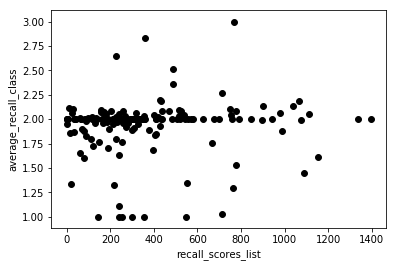

In [20]:
x = []
keys_list.sort()
for i in keys_list:
    df = pd.DataFrame(my_dict[i])
    x.append(df.describe().loc["mean"].iloc[0])
    
recall_scores_list = recall_scores.iloc[0]
average_recall_class = x
df = pd.DataFrame({"recall_scores_list": recall_scores_list, "average_recall_class": average_recall_class})
df.plot.scatter(x = "recall_scores_list", y = "average_recall_class", s = 35, c = 'black');
plt.show()

Then, we use linear regression to determine if there is a "nice" curve of best fit here.

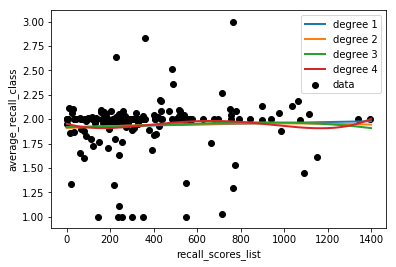

In [21]:
mr1 = sm.ols(formula="average_recall_class ~ recall_scores_list", data=df).fit()
par1 = dict(mr1.params)
mr2 = sm.ols(formula="average_recall_class ~ recall_scores_list + I(recall_scores_list ** 2.0)", data=df).fit()
par2 = dict(mr2.params)
mr3 = sm.ols(formula="average_recall_class ~ recall_scores_list + I(recall_scores_list ** 2.0) + I(recall_scores_list ** 3.0)", data=df).fit()
par3 = dict(mr3.params)
mr4 = sm.ols(formula="average_recall_class ~ recall_scores_list + I(recall_scores_list ** 2.0) + I(recall_scores_list ** 3.0) + I(recall_scores_list ** 4.0)", data=df).fit()
par4 = dict(mr4.params)

plt.scatter(df['recall_scores_list'],df['average_recall_class'],color='black',label="data")

x = sc.linspace(0,1400,1000)
y1 = par1["Intercept"] + par1['recall_scores_list']*x
y2 = par2["Intercept"] + par2['recall_scores_list']*x + par2['I(recall_scores_list ** 2.0)']*x**2
y3 = par3["Intercept"] + par3['recall_scores_list']*x + par3['I(recall_scores_list ** 2.0)']*x**2 + par3['I(recall_scores_list ** 3.0)']*x**3
y4 = par4["Intercept"] + par4['recall_scores_list']*x + par4['I(recall_scores_list ** 2.0)']*x**2 + par4['I(recall_scores_list ** 3.0)']*x**3 + par4['I(recall_scores_list ** 4.0)']*x**4

plt.plot(x,y1,label="degree 1",linewidth=2)
plt.plot(x,y2,label="degree 2",linewidth=2)
plt.plot(x,y3,label="degree 3",linewidth=2)
plt.plot(x,y4,label="degree 4",linewidth=2)
plt.legend()
plt.xlabel('recall_scores_list'); plt.ylabel('average_recall_class')
plt.show()

In [22]:
print('mr1:',mr1.rsquared)
print('mr2:',mr2.rsquared)
print('mr3:',mr3.rsquared)
print('mr4:',mr4.rsquared)

mr1: 0.001879187565128837
mr2: 0.0023483737536722504
mr3: 0.0027402539165080064
mr4: 0.006966120065192261


We know that as we increase the value of $m$, the $R^2$ value will increase as well. This is advantageous for the data we already have but may not generalize to other data. The statistical summaries of the corresponding curves of best fit are listed below. One should notice that while $R^2$ increases, it does not increase by much. There is a very percentage of the response variable variation that is explained by our models. Lastly, we should notice that the condition number of the coefficient matrices grows quickly. So, the matrices are ill-conditioned, and are subject to large changes from very small variation.

In [23]:
print("First Power Linear Regression:")
print(mr1.summary())
print('\n\n\nSecond Power Linear Regression:')
print(mr2.summary())
print('\n\n\nThird Power Linear Regression:')
print(mr3.summary())
print('\n\n\nFourth Power Linear Regression:')
print(mr4.summary())

First Power Linear Regression:
                             OLS Regression Results                             
Dep. Variable:     average_recall_class   R-squared:                       0.002
Model:                              OLS   Adj. R-squared:                 -0.004
Method:                   Least Squares   F-statistic:                    0.3069
Date:                  Sun, 21 Apr 2019   Prob (F-statistic):              0.580
Time:                          21:37:02   Log-Likelihood:                -27.653
No. Observations:                   165   AIC:                             59.31
Df Residuals:                       163   BIC:                             65.52
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------

While this is useful when determining a new firm's average recall class based on its given recall score, this is not necessarily useful for data outside the scope of the data we currently have. To derive a regression model that generalizes, we use "cross validation".

m= 1 , train:  2.2793853318159307e-05  test:  -0.028139799343029237
m= 2 , train:  0.0008560053438164683  test:  -0.031590932471669886
m= 3 , train:  0.002248359998803018  test:  -0.042318767398290325
m= 4 , train:  0.006647125324239056  test:  -0.029225796945444804
m= 5 , train:  0.0073053599101911  test:  -0.04265498452564809


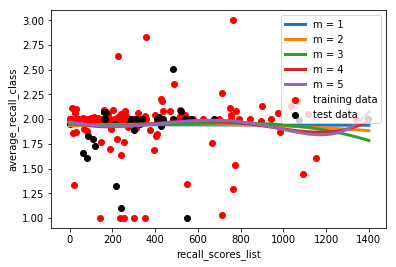

In [24]:
lr = linear_model.LinearRegression()

df['new_1'] = sc.zeros([165,1])
df['new_2'] = sc.zeros([165,1])
df['new_3'] = sc.zeros([165,1])
df['new_4'] = sc.zeros([165,1])
df['new_5'] = sc.zeros([165,1])

xs = sc.linspace(0, 1400, num=100)
Xs = sc.zeros([100,5])
Xs[:,0] = xs
for m in sc.arange(1,6): 
    df['new_'+str(m)] = df['recall_scores_list']**m

for m in sc.arange(1,5): 
    Xs[:,m] = xs**(m+1)
    
X = df[['new_1','new_2','new_3','new_4', 'new_5']].values.reshape(df['recall_scores_list'].shape[0],5)
y = df["average_recall_class"].values.reshape(df["average_recall_class"].shape[0],1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=1)

for m in sc.arange(1,2):     
    lr.fit(X=X[:,:m], y=y)

plt.scatter(X_train[:,0], y_train,  color='red',label='training data')
plt.scatter(X_test[:,0], y_test,  color='black',label='test data')

for m in sc.arange(1,6):     
    lr.fit(X=X_train[:,:m], y=y_train)
    print('m=', m, ', train: ', lr.score(X_train[:,:m], y_train), ' test: ', lr.score(X_test[:,:m], y_test))
    plt.plot(xs, lr.predict(X=Xs[:,:m]), linewidth=3, label = "m = " + str(m) )

plt.legend()
plt.xlabel('recall_scores_list'); plt.ylabel("average_recall_class")
plt.ylim((.9,3.1))
plt.show()

Again, there does not seem to exist a strong correlation between the two variables. Also, our models do not seem to generalize well to other data. The best choice seems to be a linear model.

We then move on to an analysis on the time of the year devices are recalled.

In [25]:
data = recall_df
data.groupby('RECALL_CLASS').count()

,Unnamed: 0,CENTER,CENTER_CLASSIFICATION_DT,FIRM_NAME,MANUFACTURER_RECALL_REASON,POSTED_INTERNET_DT,PRODUCT_DESCRIPTION,RECALL_NUMBER,TERMINATION_DT,TRADE_NAME,WEB_ADDRESS,ï»¿WEB_ADDRESS
RECALL_CLASS,,,,,,,,,,,,
1,1817,1817,1817,1817,1817,1817,1817,1817,1802,1815,1196,621
2,12327,12327,12327,12327,12324,12280,12327,12327,12165,12305,7615,4712
3,554,554,554,554,554,551,554,554,553,554,341,213


We saw that `CENTER_CLASSIFICATION_DT` had the most amount of data points; consequently, this was the column that was used for extracting recall dates for this particular analysis. The following code was simply some string conversions to extract the specific years and months of the recalls.

In [26]:
# adding additional columns 
data['Recall_Year'] = data['CENTER_CLASSIFICATION_DT'].str[:4].astype(int) # year
data['Recall_MY'] = data['CENTER_CLASSIFICATION_DT'].str[:4]+"."+data['CENTER_CLASSIFICATION_DT'].str[5:7]
data['Recall_Month'] = data['CENTER_CLASSIFICATION_DT'].str[5:7].astype(int) # month

data = data[data['Recall_Year'] != 2004] # removing random extra year

yr1 = data['Recall_Year'].value_counts().index.tolist()
yr2 = data['Recall_Year'].value_counts().values.tolist()
my1 = data['Recall_MY'].value_counts().index.tolist()
my2 = data['Recall_MY'].value_counts().values.tolist()
rm1 = data['Recall_Month'].value_counts().index.tolist()
rm2 = data['Recall_Month'].value_counts().values.tolist()

rc = data.groupby('RECALL_CLASS').size()

In [27]:
# relevant user-defined functions
# converting number to month
def month_switch(argument):
    switcher = {
        1: "Jan.",
        2: "Feb.",
        3: "Mar.",
        4: "Apr.",
        5: "May",
        6: "June",
        7: "July",
        8: "Aug.",
        9: "Sept.",
        10: "Oct.",
        11: "Nov.",
        12: "Dec."
    }
    return (switcher.get(argument, "Invalid month"))

# converting number (i.e. 2011.12) to a year and month
def monthyear(x):
    x = str(x)
    y = x[:4]
    m = int(float(x[5:]))
    m = month_switch(m)
    final = y + " " + str(m)
    return final

# function that isn't really used anywhere
def barlab(y):
    for i, v in enumerate(y):
        plt.text(v, i + 3, str(v), color='blue', fontweight='bold')
months = ['Jan.', 'Feb.', 'Mar.','Apr.', 'May', 'June', 'July','Aug.','Sept.','Oct.','Nov.','Dec.']

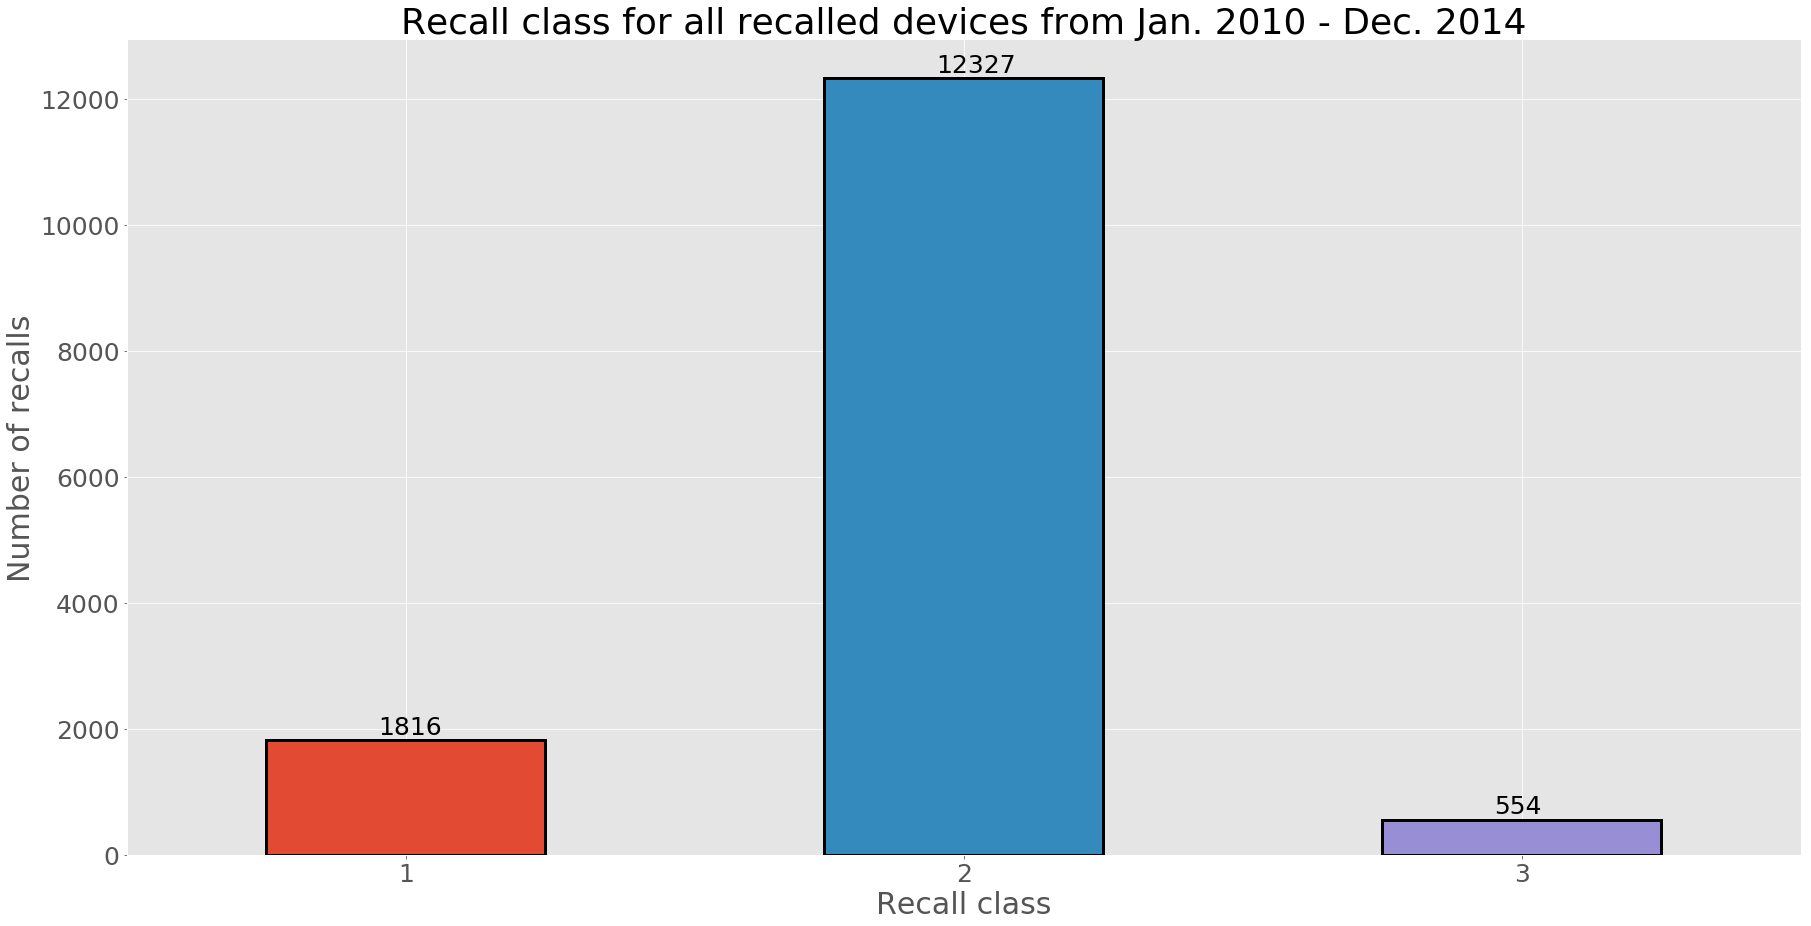

In [28]:
plt.rcParams['figure.figsize'] = (30,15)
plt.style.use('ggplot')
plt.rcParams.update({'font.size': 25})

rc.plot.bar(edgecolor="black", linewidth="3")
plt.title("Recall class for all recalled devices from Jan. 2010 - Dec. 2014")
plt.xlabel("Recall class")
plt.ylabel("Number of recalls")
plt.xticks(rotation="horizontal");

for i in range(3):
    plt.text(i-0.05, rc.loc[i+1]+100, rc.loc[i+1])

From this graph, we can see that a vast majority of the recalled data has a recall class of 2. Few have a recall class of 3, and almost 2000 have a recall class of 1. Generally, the lower the recall class, the more severe the recall. So, a recall class of 1 means that the recall needs to be addressed as soon as possible.

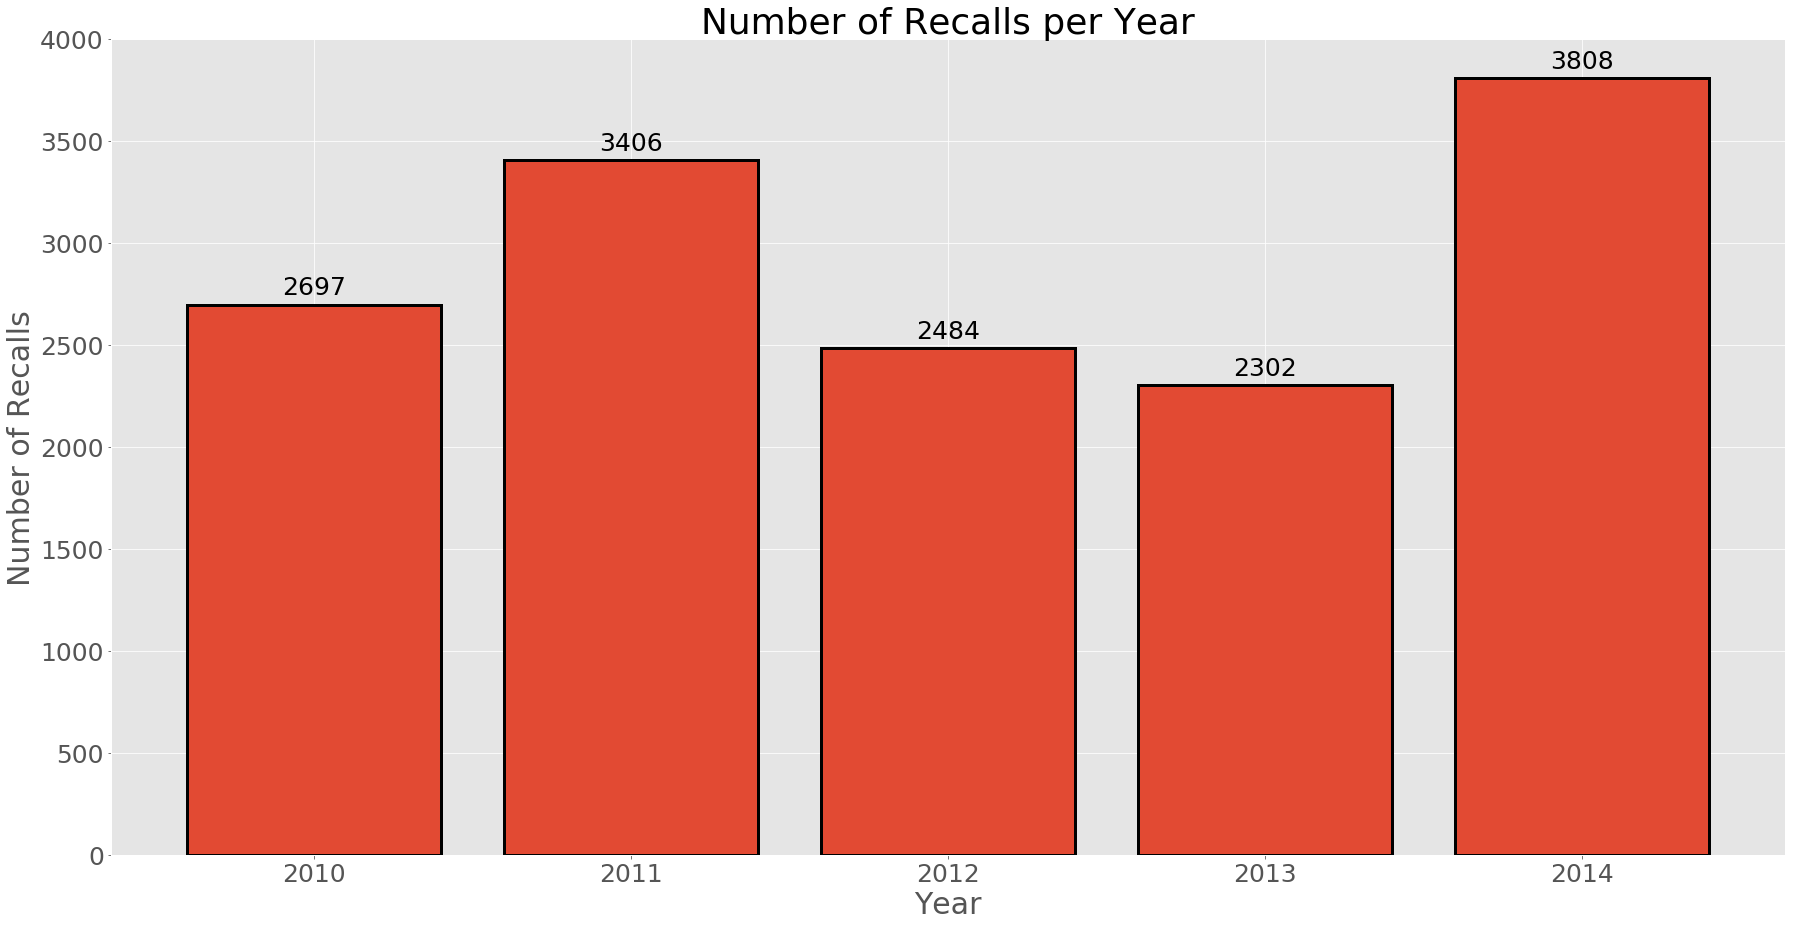

In [29]:
plt.rcParams['figure.figsize'] = (30,15)
plt.style.use('ggplot')
plt.rcParams.update({'font.size': 25})

# plotting recalls per year

plt.bar(yr1, yr2, edgecolor="black", linewidth="3")
plt.title("Number of Recalls per Year");
plt.xlabel("Year");
plt.ylabel("Number of Recalls");
for i in range(len(yr2)):
    plt.text(yr1[i]-0.1, yr2[i]+50, yr2[i])

We can see that there isn't really a trend of recalls per year. The year 2014 had the most amount of recalls compared to all of the other years, but there isn't an obvious trend that we can see here.

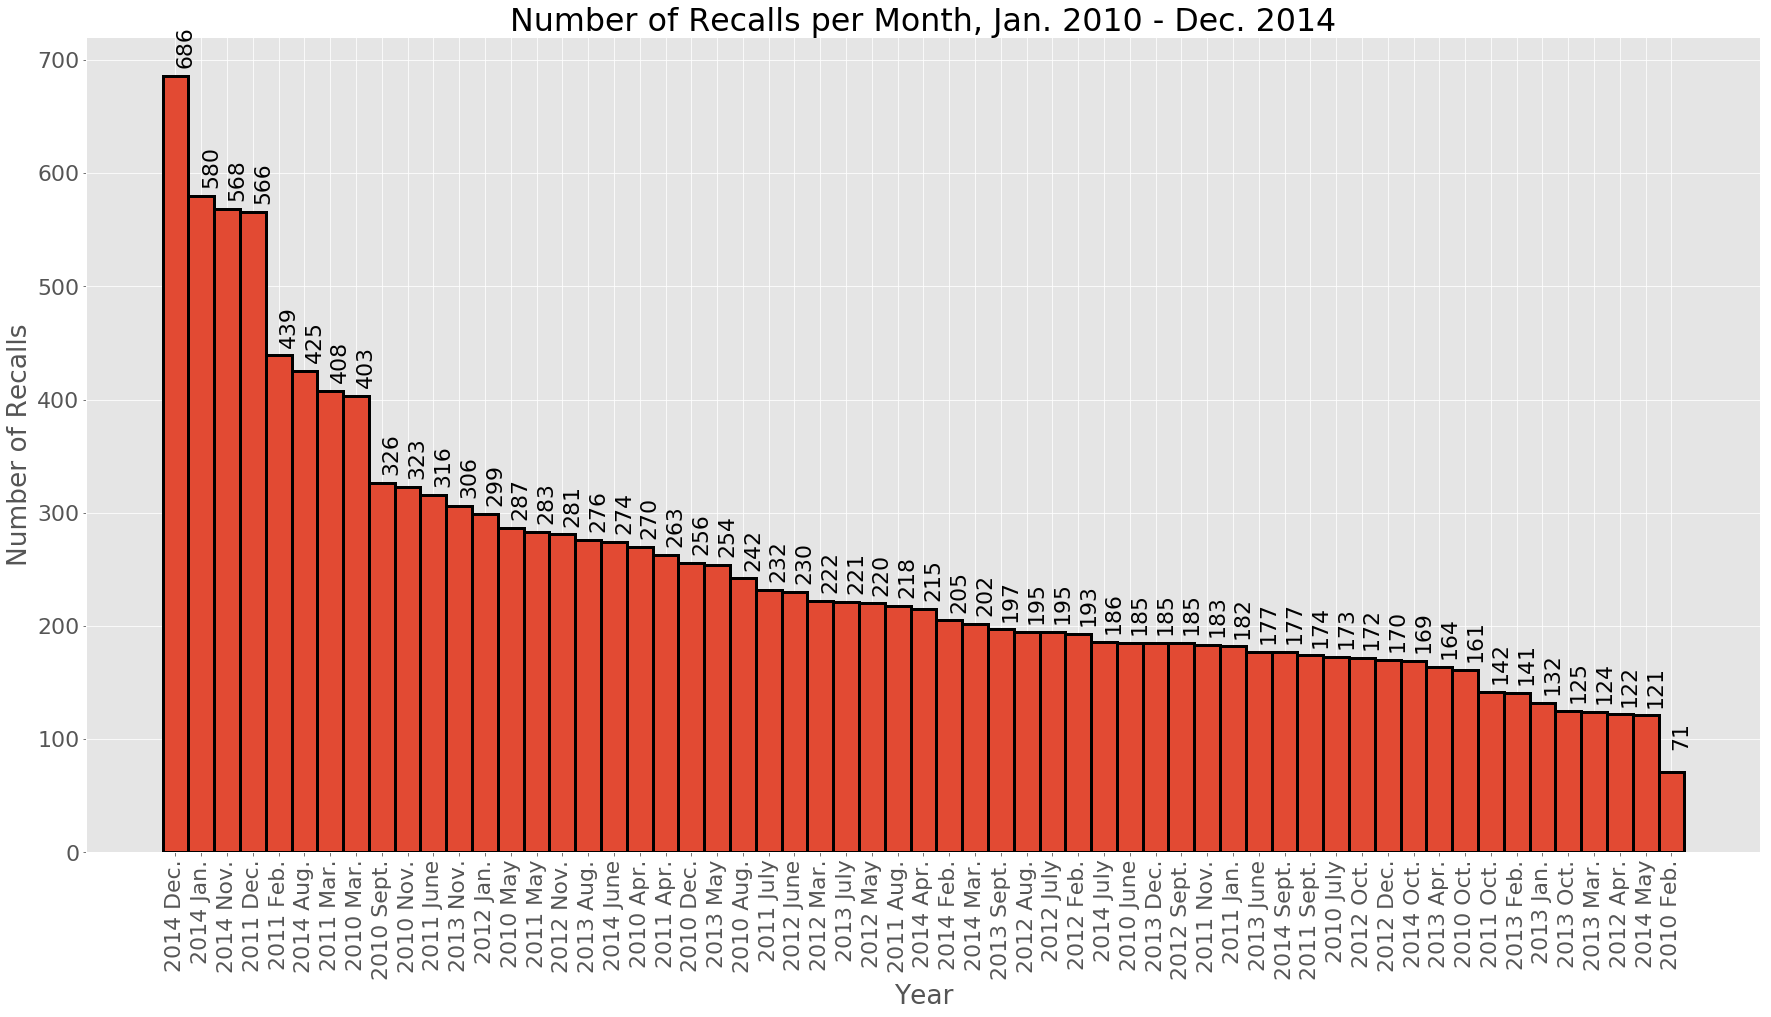

In [30]:
plt.rcParams['figure.figsize'] = (30,15)
plt.style.use('ggplot')
plt.rcParams.update({'font.size': 22})

# graphing month/year recalls
idk = [monthyear(x) for x in my1] # month and year of recall
plt.bar(idk,my2, edgecolor="black", linewidth="3", width=1)
plt.title("Number of Recalls per Month, Jan. 2010 - Dec. 2014")
plt.xlabel("Year")
plt.ylabel("Number of Recalls")
plt.xticks(rotation="vertical");
for i in range(len(my2)):
    plt.text(idk[i], my2[i]+30, my2[i], rotation=90)

We can see here that December 2014 was the most popular month for devices to be recalled, amounting to 686 recalls in that month alone. The next highest months are either at the beginning of the year or near the end of the year, until August 2014, which had 425 recalls in that month.

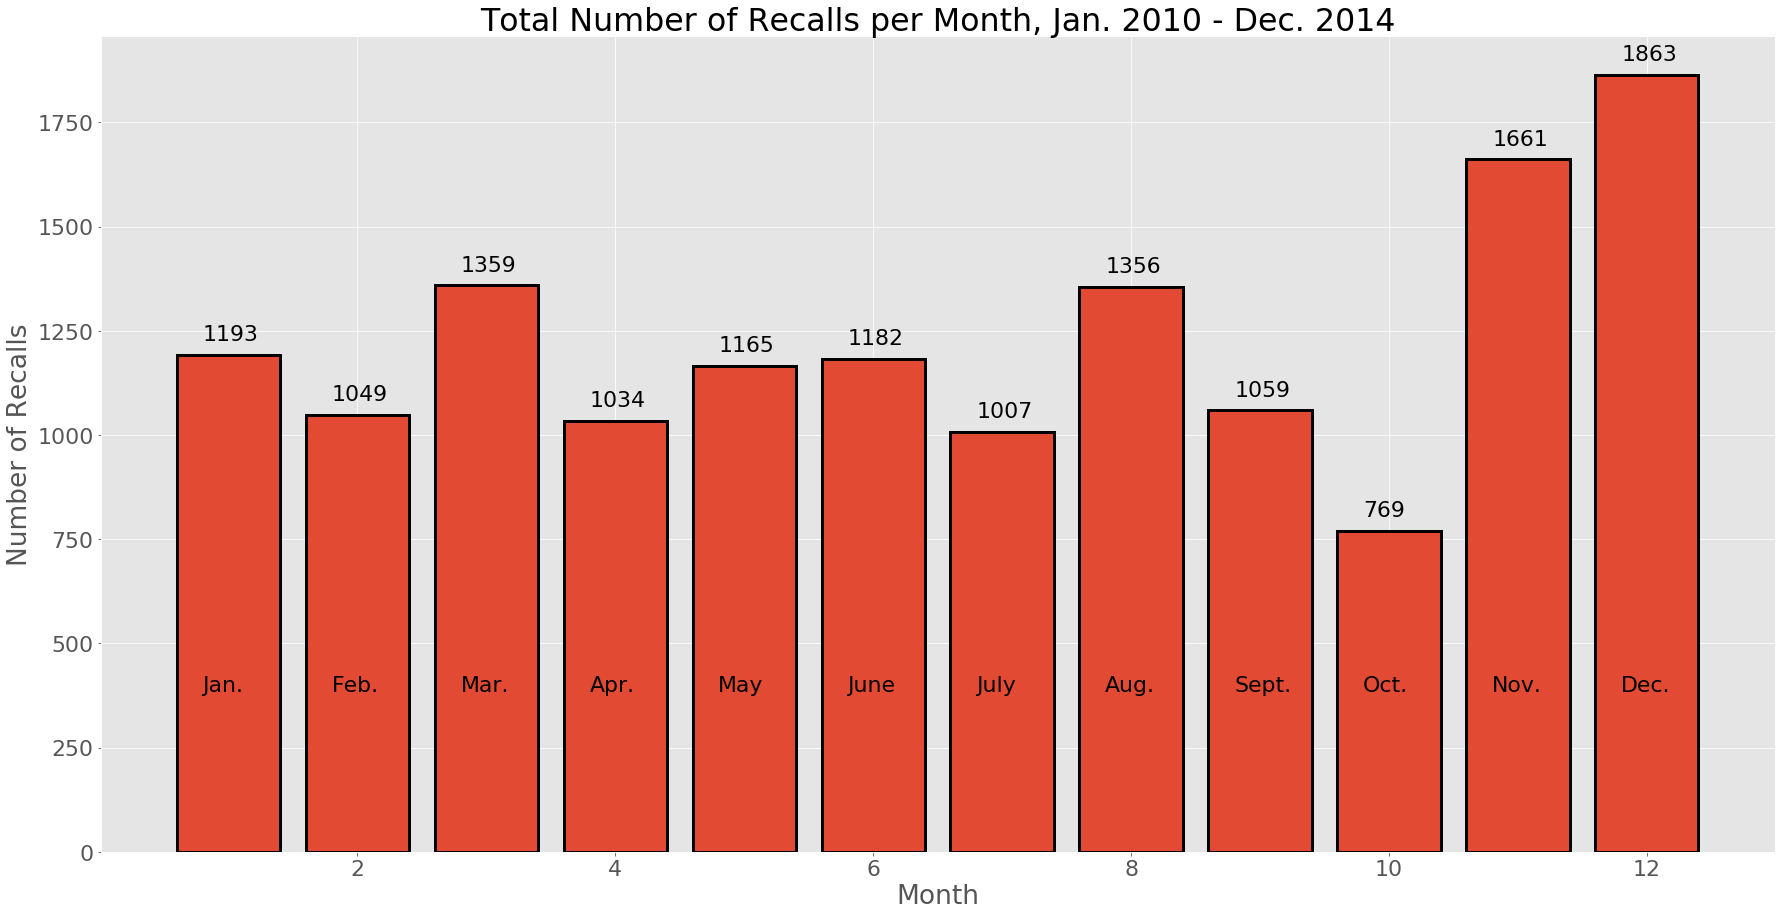

In [31]:
plt.rcParams['figure.figsize'] = (30,15)
plt.style.use('ggplot')
plt.rcParams.update({'font.size': 22})

# plotting recalls per month by totalling all recalls in a month, over five years
plt.bar(rm1,rm2, edgecolor="black", linewidth="3")
plt.title("Total Number of Recalls per Month, Jan. 2010 - Dec. 2014");
plt.xlabel("Month");
plt.ylabel("Number of Recalls");
for i in range(len(rm2)):
    plt.text(rm1[i]-0.2, rm2[i]+35, rm2[i])
for j in range(12):
    plt.text(j+0.8, min(rm2)/2, months[j])

Following up from the previous graph, we see that December in general tends to have the most recalled devices, with November following it. August and March come in third place for recalls. Interestingly enough, October has the least amount of recalls, despite it being directly before November and December.

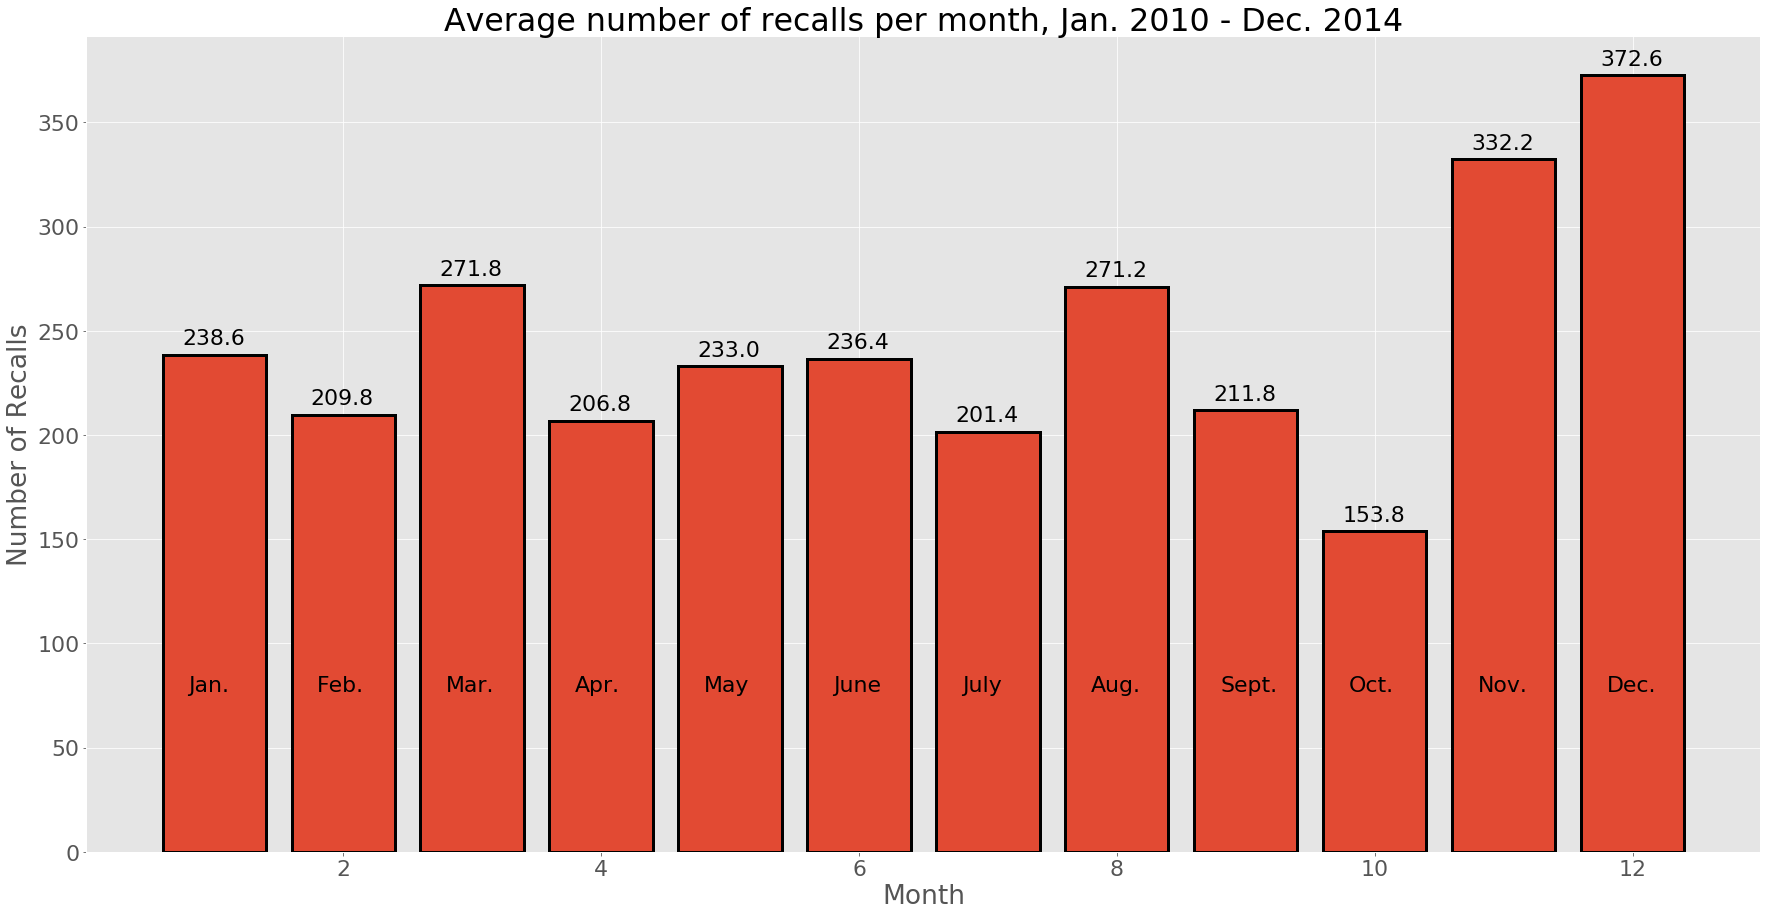

In [32]:
plt.rcParams['figure.figsize'] = (30,15)
plt.style.use('ggplot')
plt.rcParams.update({'font.size': 22})

# average recalls per month, essentially scaling down the previous plot

rm2a = [x / 5 for x in rm2] # average
plt.bar(rm1,rm2a, edgecolor="black", linewidth="3")
plt.title("Average number of recalls per month, Jan. 2010 - Dec. 2014");
plt.xlabel("Month");
plt.ylabel("Number of Recalls");
for i in range(len(rm2a)):
    plt.text(rm1[i]-0.25, rm2a[i]+5, rm2a[i])
for j in range(12):
    plt.text(j+0.8, min(rm2a)/2, months[j])

This graph is the scaled down version of the previous graph, as it simply takes the previous numbers and divides them by the number of years -- in this case, 5. The trends stated here are identical, but it does give a better idea of how many devices are recalled in each month in a single year.

Now that we've seen how recalls are distributed amongst the years, let's try something similar to what we did with the device reports and attempt to predict the month that a device was recalled in based on the description of the recall.

In [33]:
#recall_df = recall_df.drop(['Unnamed: 0','CENTER','WEB_ADDRESS','ï»¿WEB_ADDRESS'], axis=1)#Get rid of columns that don't matter
def month_switch(argument):# Redefining month_switch so it will work on the dates in the "POSTED_INTERNET_DT" column
    switcher = {
        '01': "Jan.",
        '02': "Feb.",
        '03': "Mar.",
        '04': "Apr.",
        '05': "May",
        '06': "June",
        '07': "July",
        '08': "Aug.",
        '09': "Sept.",
        '10': "Oct.",
        '11': "Nov.",
        '12': "Dec."
    }
    return (switcher.get(argument, "Invalid month"))
recall_df['Month'] = recall_df['POSTED_INTERNET_DT'].apply(lambda x: month_switch(str(x)[5:7]))

In [34]:
#Converting the recall reasons into something we can vectorize
recall_rsns = []
for rsn in recall_df['MANUFACTURER_RECALL_REASON']:
    recall_rsns.append(str(rsn))

Again, we are going to test each vectorizer with alpha ranging from 0.05 to 1.0.

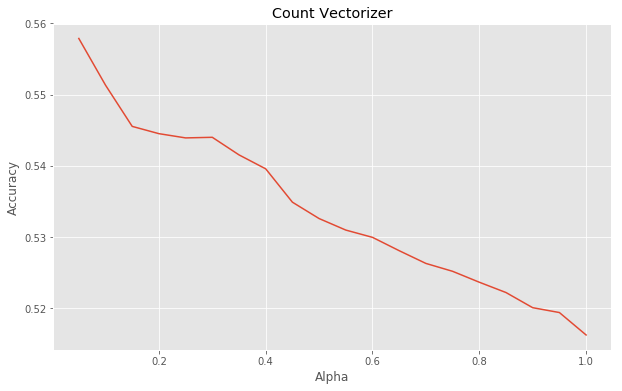

Highest Accuracy: 0.5578705672251042
Alpha = 0.05


In [35]:
plt.rcParams['figure.figsize'] = (10,6)
plt.style.use('ggplot')
plt.rcParams.update({'font.size': 10})
#Vectorizing the reasons with the Count Vectorizer
X = countv.fit_transform(recall_rsns)
y = recall_df['Month']
accuracies = []
alpha = []
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, test_size=0.8)
for a in np.arange(0.05, 1.05, .05):
    nb_model = MultinomialNB(alpha=a)
    nb_model.fit(X_train, y_train)
    y_pred = nb_model.predict(X_test)
    accuracies.append(metrics.accuracy_score(y_true=y_test, y_pred=y_pred))
    alpha.append(a)
plt.plot(alpha,accuracies)
plt.title('Count Vectorizer')
plt.xlabel('Alpha')
plt.ylabel('Accuracy')
plt.show()
print('Highest Accuracy:',max(accuracies))
print('Alpha =',alpha[accuracies.index(max(accuracies))])

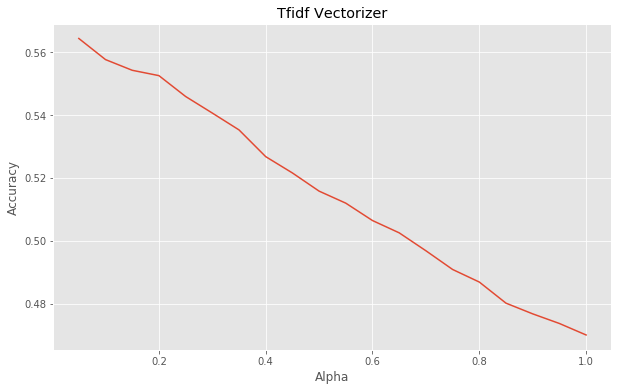

Highest Accuracy: 0.564333701845395
Alpha = 0.05


In [36]:
X = tfidfv.fit_transform(recall_rsns)
y = recall_df['Month']
accuracies = []
alpha = []
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, test_size=0.8)
for a in np.arange(0.05, 1.05, .05):
    nb_model = MultinomialNB(alpha=a)
    nb_model.fit(X_train, y_train)
    y_pred = nb_model.predict(X_test)
    accuracies.append(metrics.accuracy_score(y_true=y_test, y_pred=y_pred))
    alpha.append(a)
plt.plot(alpha,accuracies)
plt.title('Tfidf Vectorizer')
plt.xlabel('Alpha')
plt.ylabel('Accuracy')
plt.show()
print('Highest Accuracy:',max(accuracies))
print('Alpha =',alpha[accuracies.index(max(accuracies))])

This time, the two vectorizers had similar accuracy overall and only achieved a maximum accuracy of ~56%. Since the recall description turned out to be a poor predictor, let's instead try using the product description as our predictor.

In [37]:
#Converting descriptions into something we can vectorize
recall_descr = []
for descr in recall_df['PRODUCT_DESCRIPTION']:
    recall_descr.append(str(descr))

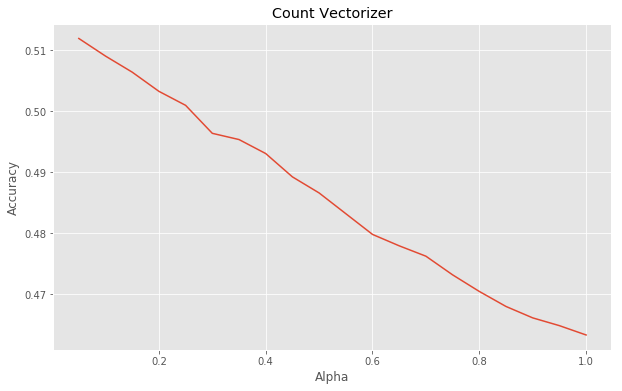

Highest Accuracy: 0.5119482949230377
Alpha = 0.05


In [38]:
X = countv.fit_transform(recall_descr)
y = recall_df['Month']
accuracies = []
alpha = []
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, test_size=0.8)
for a in np.arange(0.05, 1.05, .05):
    nb_model = MultinomialNB(alpha=a)
    nb_model.fit(X_train, y_train)
    y_pred = nb_model.predict(X_test)
    accuracies.append(metrics.accuracy_score(y_true=y_test, y_pred=y_pred))
    alpha.append(a)
plt.plot(alpha,accuracies)
plt.title('Count Vectorizer')
plt.xlabel('Alpha')
plt.ylabel('Accuracy')
plt.show()
print('Highest Accuracy:',max(accuracies))
print('Alpha =',alpha[accuracies.index(max(accuracies))])

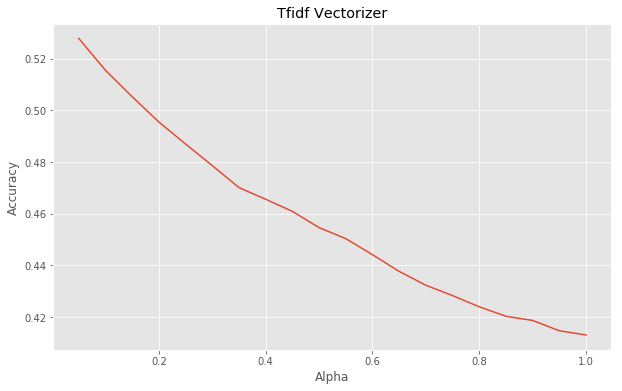

Highest Accuracy: 0.5277659664937495
Alpha = 0.05


In [39]:
X = tfidfv.fit_transform(recall_descr)
y = recall_df['Month']
accuracies = []
alpha = []
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, test_size=0.8)
for a in np.arange(0.05, 1.05, .05):
    nb_model = MultinomialNB(alpha=a)
    nb_model.fit(X_train, y_train)
    y_pred = nb_model.predict(X_test)
    accuracies.append(metrics.accuracy_score(y_true=y_test, y_pred=y_pred))
    alpha.append(a)
plt.plot(alpha,accuracies)
plt.title('Tfidf Vectorizer')
plt.xlabel('Alpha')
plt.ylabel('Accuracy')
plt.show()
print('Highest Accuracy:',max(accuracies))
print('Alpha =',alpha[accuracies.index(max(accuracies))])

Using the device description turned out to be an even worse predictor than the recall description, only achieving a maximum accuracy of ~52%. These results indicate that specific types of medical devices don't seem to be recalled at any specific time of year.

### Ethical Considerations
There are some ethical dilemmas that arise when doing analysis on "old" data. Any number of factors, such as: management, firm conduct, or economic factors may have changed since the 2010-2014 timeframe we're considering. This could alter the data in several ways. If this data is altered, then this analysis may make some firms look "better" than they really are, unduly increasing business. But on the other hand, it could put other firms in a bad light that don't deserve it, and drive business away. If we needed truly accurate results, then we would have to consider a more current timeframe. Again, all the results above may or may not still be accurate, so I would not advise consumers to make decisions based off it.

Another ethical dilemma we should consider is the fact that we could not extract all coordinates from the dataset we had. We created our visualizations and models in part 1 under the assumption that the half of the data that we collected was representative of the original database. Of course, maybe we only saw more devices in the U.S. simply due to a bias towards U.S. cities inside the database of cities.

Another point that is worth mentioning is the fact that the FDA is in the United States and is responsible for monitoring devices marketed *only* in the United States. That is to say, any devices that a company markets outside of the United States is not accounted for in our data. Because we are considering only United States devices, our resuls are not necessarily representative of a company's worldwide standing.


### Conclusion

We found many interesting results from our analysis, but we were somewhat limited by the data we had. In the analysis of our coordinate databases, we tried to predict where a device was located based on its description. From the results, you can see we got about 85% accuracy. While this result may seem impressive, it should be noted that about 75% of the devises were known to be made in north America. But when we split it up between Eastern United States and Western United States, we saw that about 35% of the devices were in the western coast of the U.S. Our model achieved an accuracy of about 81%, indicating that the generic name of the device (i.e. the type of device) is a fairly good predictor of where the deice was manufactured. This analysis led to some interesting visualizations.

In the analysis of the recall database, after we manually cleaned the grouped the medical device firm with like names, we derived a metric to measure firm's reliability. We then used linear regression and cross validation to get a model to predict a firm's average recall based on this metric we derived. From there we analyzed trends in the time of the year these devices were recalled. This led to some insights and visualizations while no trends were inherently obvious from the visualizations, these graphs allowed us to generate initial observations and could also serve as an avenue for future investigation. Lastly, we attempted to predict the month that a device was recalled based on the description of the recall.

In the end, we answered our questions "How do we determine where a device is made, based on its product description?" and "How to determine the reliability of a firm?" to the best of our ability, while answering auxiliary questions along the way. We believe that this project could provide valuable information for a consumer, if we chose a more current timeframe for the data.
